# X-Band PPI Analysis
During this same analysis period, there was an X-Band radar operated by CSU scanning in both PPI/RHI scan modes

## Imports


In [30]:
import pyart
import glob
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from math import atan2 as atan2
import warnings
warnings.filterwarnings("ignore")

## Data Overview
The data were accessed from the ARM data portal - [here is a link to the specific query](https://adc.arm.gov/discovery/#/results/datastream::gucxprecipradarS2.00), with our date being March 14, 2022


We will be looking at the 6 degree elevation scan, since there is better data coverage in the clouds/less beam blockage due to terrain

## Analysis Workflow

### Read in the Data
We grab the files from the following directory, after ordering from the data portal and unzipping the archive

In [7]:
radar_files = sorted(glob.glob('../../data/x-band/ppi/*6_PPI.nc'))

### Setup Helper Functions
We include some helper functions to build the scale bar for the plots

In [8]:
def gc_latlon_bear_dist(lat1, lon1, bear, dist):
    """
    Input lat1/lon1 as decimal degrees, as well as bearing and distance from
    the coordinate. Returns lat2/lon2 of final destination. Cannot be
    vectorized due to atan2.
    """
    re = 6371.1  # km
    lat1r = np.deg2rad(lat1)
    lon1r = np.deg2rad(lon1)
    bearr = np.deg2rad(bear)
    lat2r = np.arcsin((np.sin(lat1r) * np.cos(dist/re)) +
                      (np.cos(lat1r) * np.sin(dist/re) * np.cos(bearr)))
    lon2r = lon1r + atan2(np.sin(bearr) * np.sin(dist/re) *
                          np.cos(lat1r), np.cos(dist/re) - np.sin(lat1r) *
                          np.sin(lat2r))
    return np.rad2deg(lat2r), np.rad2deg(lon2r)
 
    
def add_scale_line(scale, ax, projection, color='k',
                  linewidth=None, fontsize=None, fontweight=None):
    """
    Adds a line that shows the map scale in km. The line will automatically
    scale based on zoom level of the map. Works with cartopy.
 
    Parameters
    ----------
    scale : scalar
        Length of line to draw, in km.
    ax : matplotlib.pyplot.Axes instance
        Axes instance to draw line on. It is assumed that this was created
        with a map projection.
    projection : cartopy.crs projection
        Cartopy projection being used in the plot.
 
    Other Parameters
    ----------------
    color : str
        Color of line and text to draw. Default is black.
    """
    frac_lat = 0.1  # distance fraction from bottom of plot
    frac_lon = 0.5  # distance fraction from left of plot
    e1 = ax.get_extent()
    center_lon = e1[0] + frac_lon * (e1[1] - e1[0])
    center_lat = e1[2] + frac_lat * (e1[3] - e1[2])
    # Main line
    lat1, lon1 = gc_latlon_bear_dist(
        center_lat, center_lon, -90, scale / 2.0)  # left point
    lat2, lon2 = gc_latlon_bear_dist(
        center_lat, center_lon, 90, scale / 2.0)  # right point
    if lon1 <= e1[0] or lon2 >= e1[1]:
        warnings.warn('Scale line longer than extent of plot! ' +
                      'Try shortening for best effect.')
    ax.plot([lon1, lon2], [lat1, lat2], linestyle='-',
            color=color, transform=projection, 
            linewidth=linewidth)
    # Draw a vertical hash on the left edge
    lat1a, lon1a = gc_latlon_bear_dist(
        lat1, lon1, 180, frac_lon * scale / 20.0)  # bottom left hash
    lat1b, lon1b = gc_latlon_bear_dist(
        lat1, lon1, 0, frac_lon * scale / 20.0)  # top left hash
    ax.plot([lon1a, lon1b], [lat1a, lat1b], linestyle='-',
            color=color, transform=projection, linewidth=linewidth)
    # Draw a vertical hash on the right edge
    lat2a, lon2a = gc_latlon_bear_dist(
        lat2, lon2, 180, frac_lon * scale / 20.0)  # bottom right hash
    lat2b, lon2b = gc_latlon_bear_dist(
        lat2, lon2, 0, frac_lon * scale / 20.0)  # top right hash
    ax.plot([lon2a, lon2b], [lat2a, lat2b], linestyle='-',
            color=color, transform=projection, linewidth=linewidth)
    # Draw scale label
    ax.text(center_lon, center_lat - frac_lat * (e1[3] - e1[2]) / 4.0,
            str(int(scale)) + ' km', horizontalalignment='center',
            verticalalignment='center', color=color, fontweight=fontweight,
            fontsize=fontsize)

### Configure our Main Plotting Function

We use the [`RadarMapDisplay`](https://arm-doe.github.io/pyart/API/generated/pyart.graph.RadarMapDisplay.html?highlight=radarmapdisplay#pyart.graph.RadarMapDisplay) from PyART as the main plotting utility, with a few customizations

In [38]:
def plot_ppi(file, centerlon, centerlat, other_field='ZDR'):
    
    # Read in the data using pyart
    radar = pyart.io.read_cfradial(file)
    
    # Quickly qc data using velocity texture
    vel_texture = pyart.retrieve.calculate_velocity_texture(radar, vel_field='VEL', wind_size=3, nyq=33.4)
    radar.add_field('velocity_texture', vel_texture, replace_existing=True)
    
    # Add a gatefilter, and filter using a threshold value of 4 - could be refined
    gatefilter = pyart.filters.GateFilter(radar)
    gatefilter.exclude_above('velocity_texture', 4)
    
    # Setup our figure
    fig = plt.figure(figsize=(30, 10))
    
    #delta lat lon degrees
    window = 0.2
    locbox = [centerlon - window, centerlon + window, centerlat - window, centerlat + window]
    
    # create the plot
    ax1 = fig.add_subplot(121, projection=ccrs.PlateCarree())
    
    # Setup a RadarMapDisplay, which gives our axes in lat/lon
    display = pyart.graph.RadarMapDisplay(radar)
    
    # Add our reflectivity (DBZ) field to the plot, including our gatefilter
    display.plot_ppi_map('DBZ', 0, ax=ax1, vmin=-20, vmax=40.,
                         gatefilter=gatefilter)
    
    # Set our bounds
    plt.xlim(locbox[0], locbox[1])
    plt.ylim(locbox[2], locbox[3])
    
    # Label where the KAZR radar is at and place the legend in the upper right
    ax1.scatter(centerlon, centerlat, marker='o', s=100, color='k',
                label='KAZR Radar')
    plt.legend(loc='upper right')
    
    # Add our scale bar
    add_scale_line(10.0, ax1, projection=ccrs.PlateCarree(), 
                   color='black', linewidth=3,
                   fontsize=20,
                   fontweight='bold')
    
    # Part 2 - plot either ZDR or PHIDP
    ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree())
    
    if other_field == 'ZDR':
        
        # Plot ZDR, using the bounds discussed on Slack - notice the negative values
        display.plot_ppi_map('ZDR', 0, ax=ax2, vmin=-1.5, vmax=0.,
                             gatefilter=gatefilter,
                             cmap='pyart_Carbone42')
        
    elif other_field == 'PHIDP':
    
        display.plot_ppi_map('PHIDP', 0, ax=ax2,
                             vmin=90, vmax=120,
                             gatefilter=gatefilter,
                             cmap='pyart_Carbone42')
    
    # Adjust the bounds
    plt.xlim(locbox[0], locbox[1])
    plt.ylim(locbox[2], locbox[3])
    
    # Add a point for the KAZR radar
    ax2.scatter(centerlon, centerlat, marker='o', s=100, color='k',
                label='KAZR Radar')
    plt.legend(loc='upper right')
    
    # Add a scale bar
    add_scale_line(10.0, ax2, projection=ccrs.PlateCarree(), 
                   color='black', linewidth=3,
                   fontsize=20,
                   fontweight='bold')
    
    # Create the image path from the time
    image_path = f"../images/xband_ppi/xband_ppi_{radar.time['units'][-8:].replace(':', '.')}.png"

    # Make sure it has a white background - helps with dark mode in slack
    plt.savefig(image_path, facecolor='white', transparent=False)
    
    # Show the figure, then close!
    plt.show()
    plt.close()

### Test the Plotting on a Single File
Let's test out this function on a single file...

We also need to read in the lat/lon of the KAZR radar

In [32]:
kazr_ds = xr.open_dataset('../../data/ka-band/guckazrcfrgeM1.a1.20220314.000003.nc')

We can grab the latitude and longitude from this dataset...

In [33]:
lat = kazr_ds.latitude.values
lon = kazr_ds.longitude.values
print(f'{lat}, {lon}')

38.95615768432617, -106.98785400390625


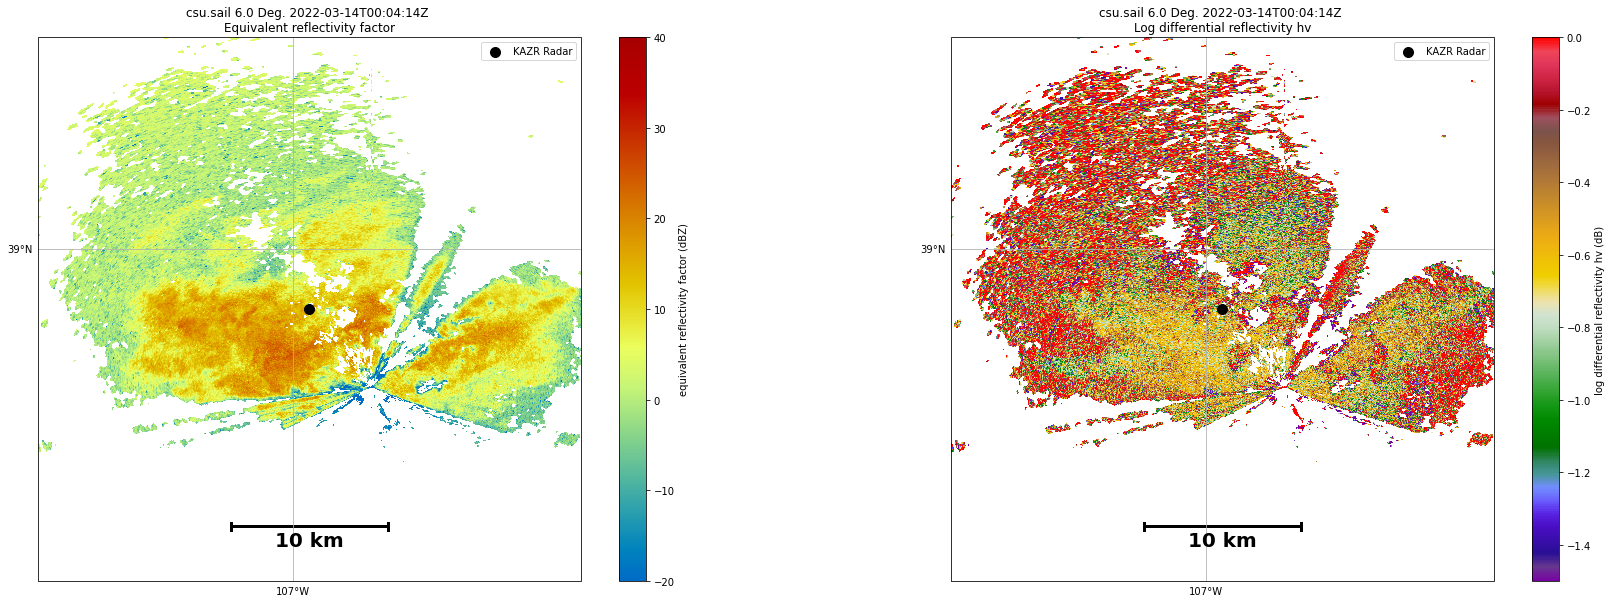

In [34]:
plot_ppi(file=radar_files[0],
         centerlat=lat,
         centerlon=lon)

## Final Data Visualization
Let's plot all of our files!

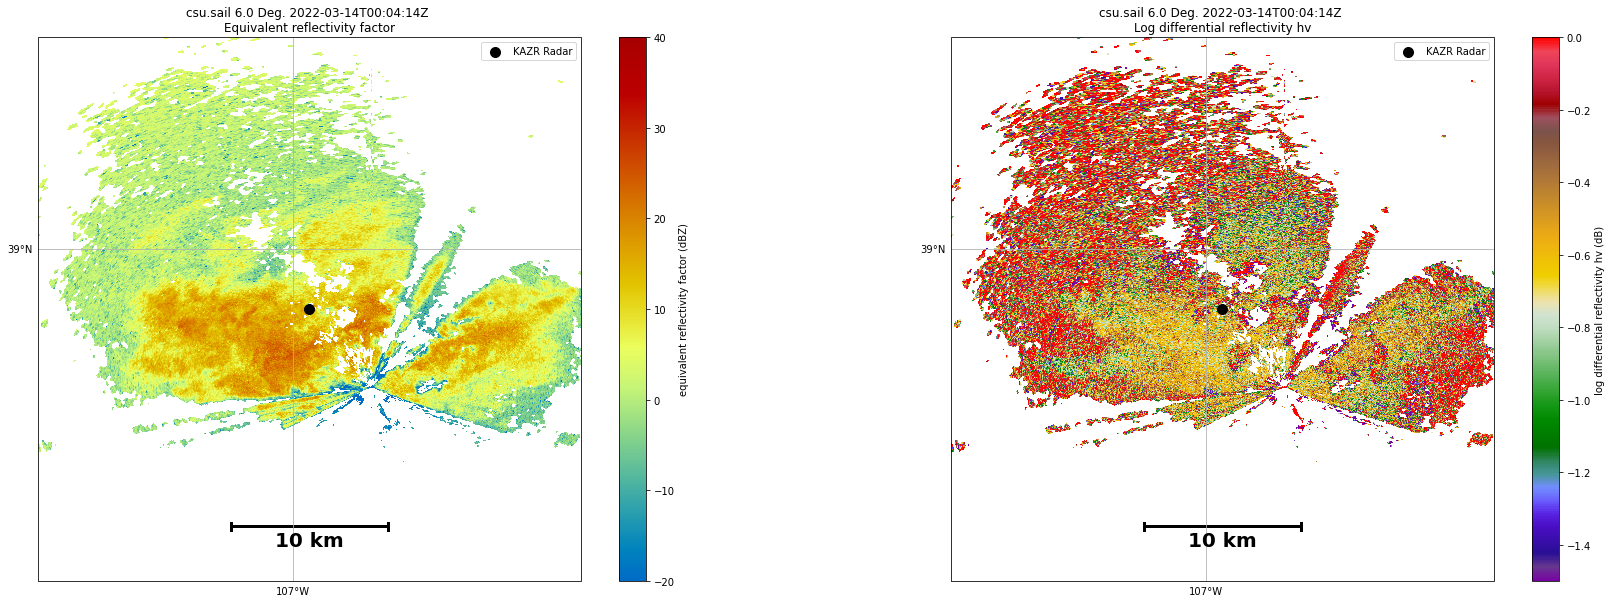

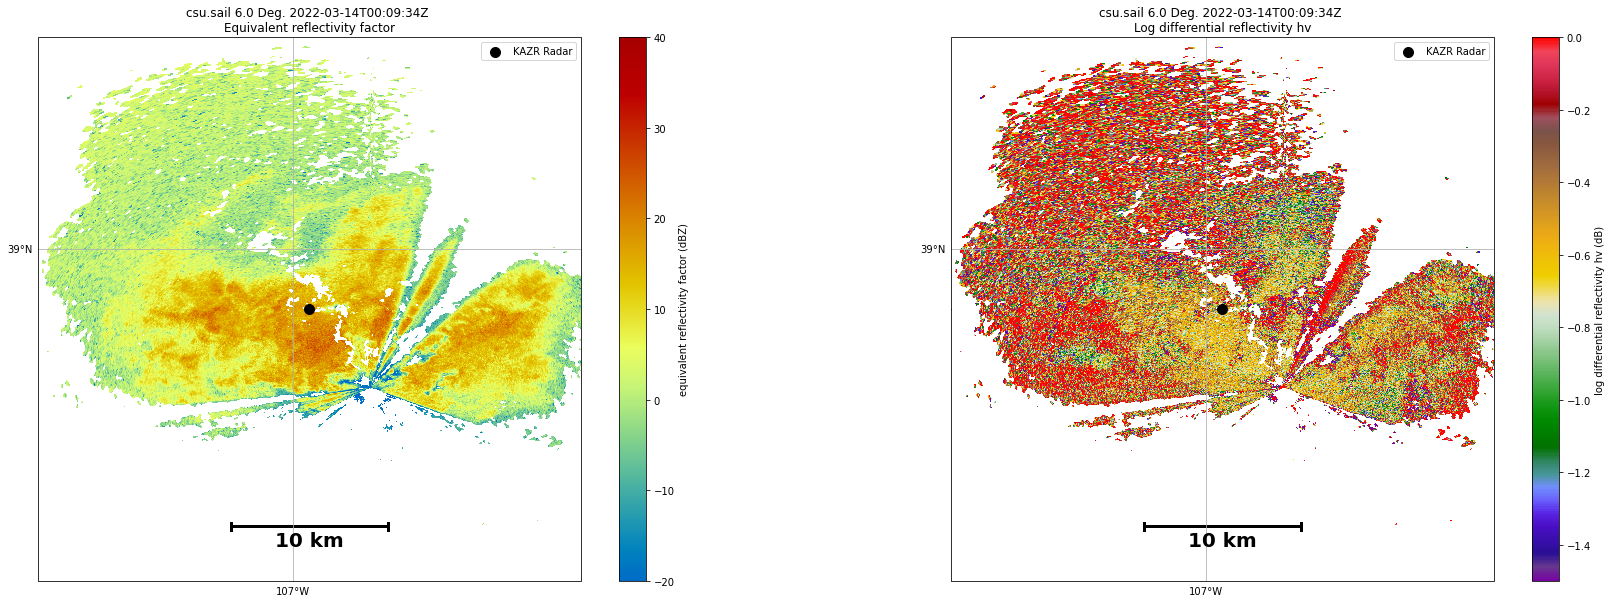

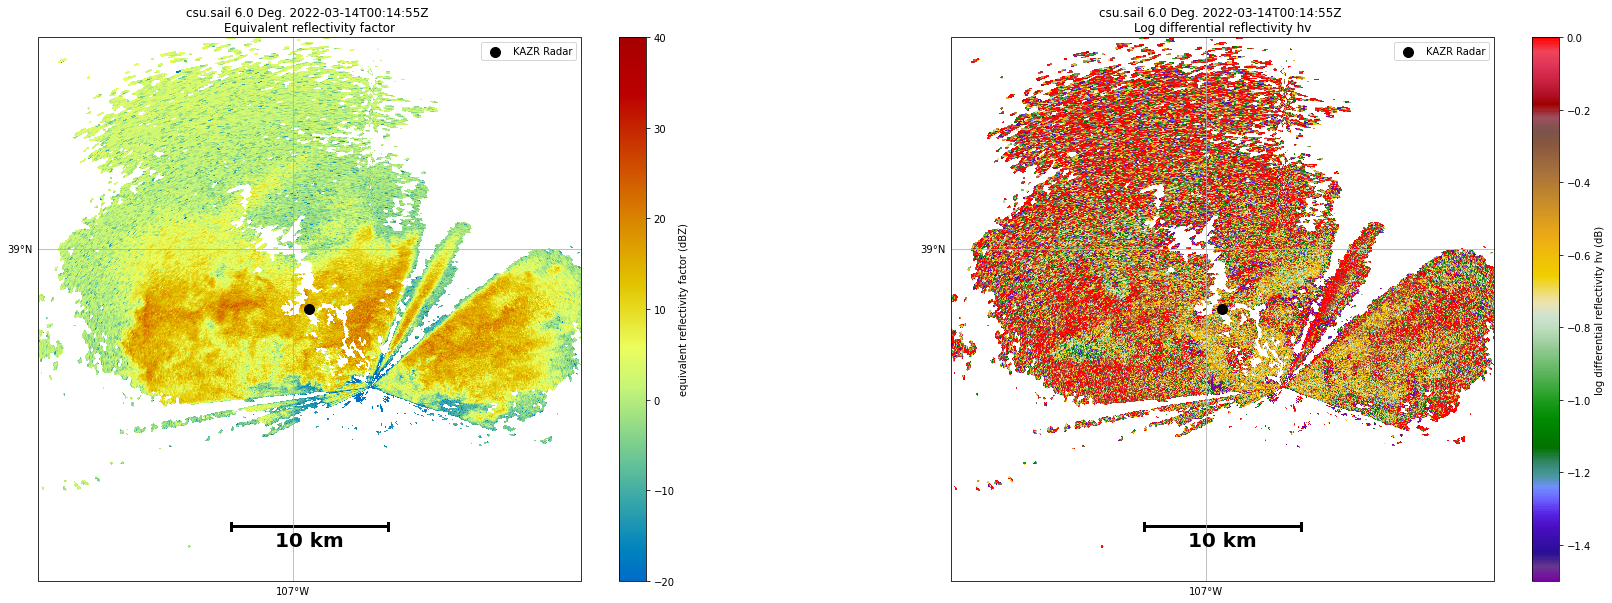

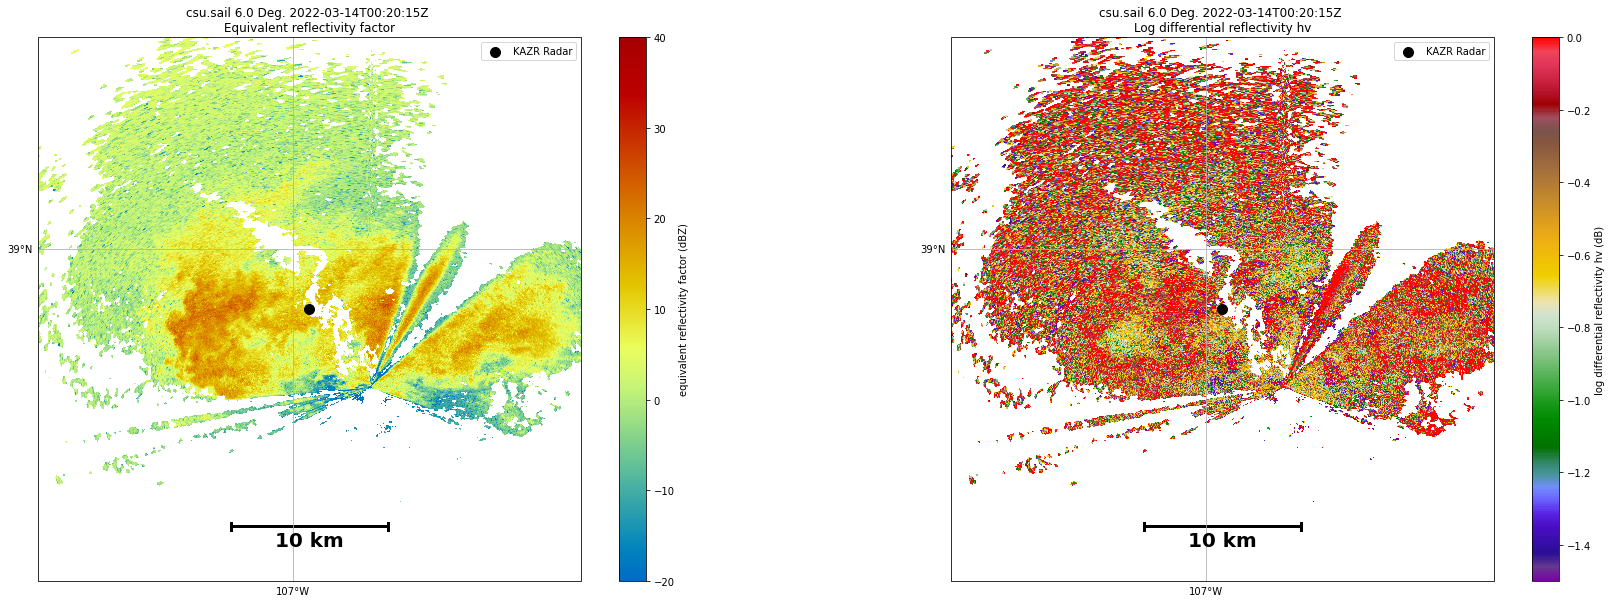

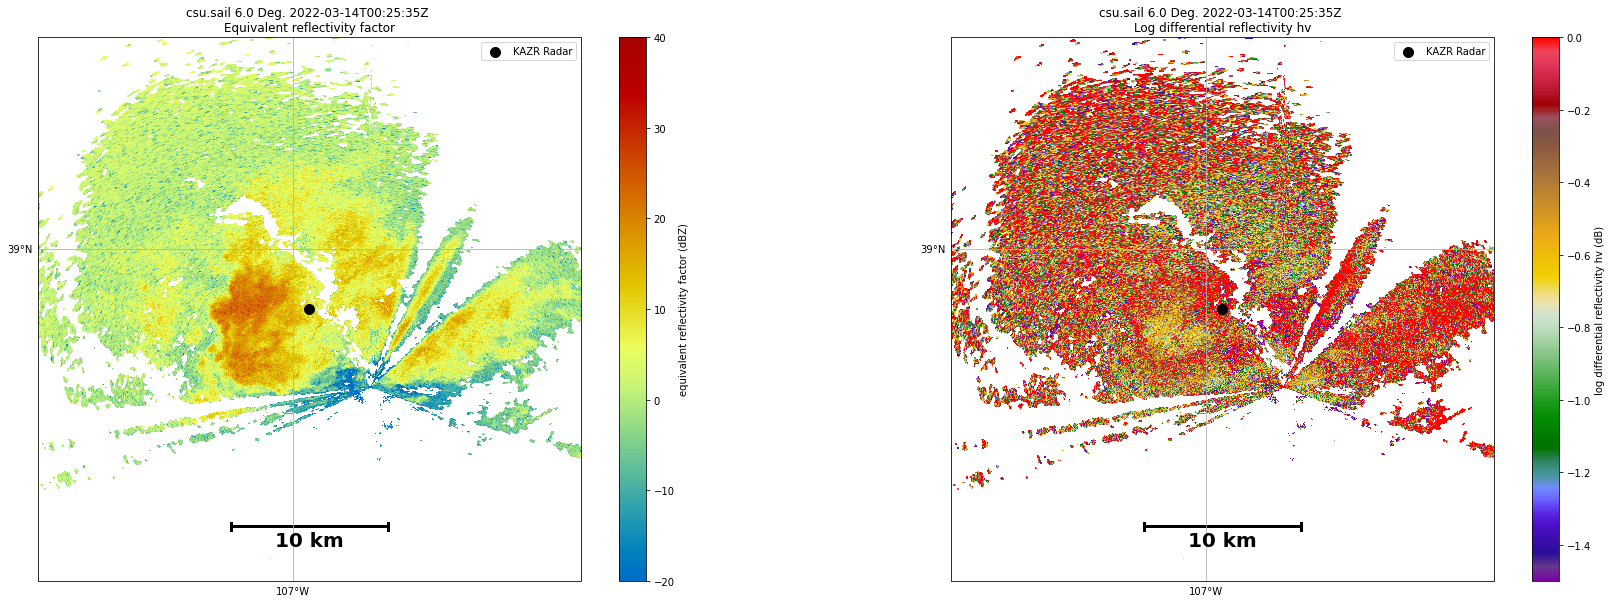

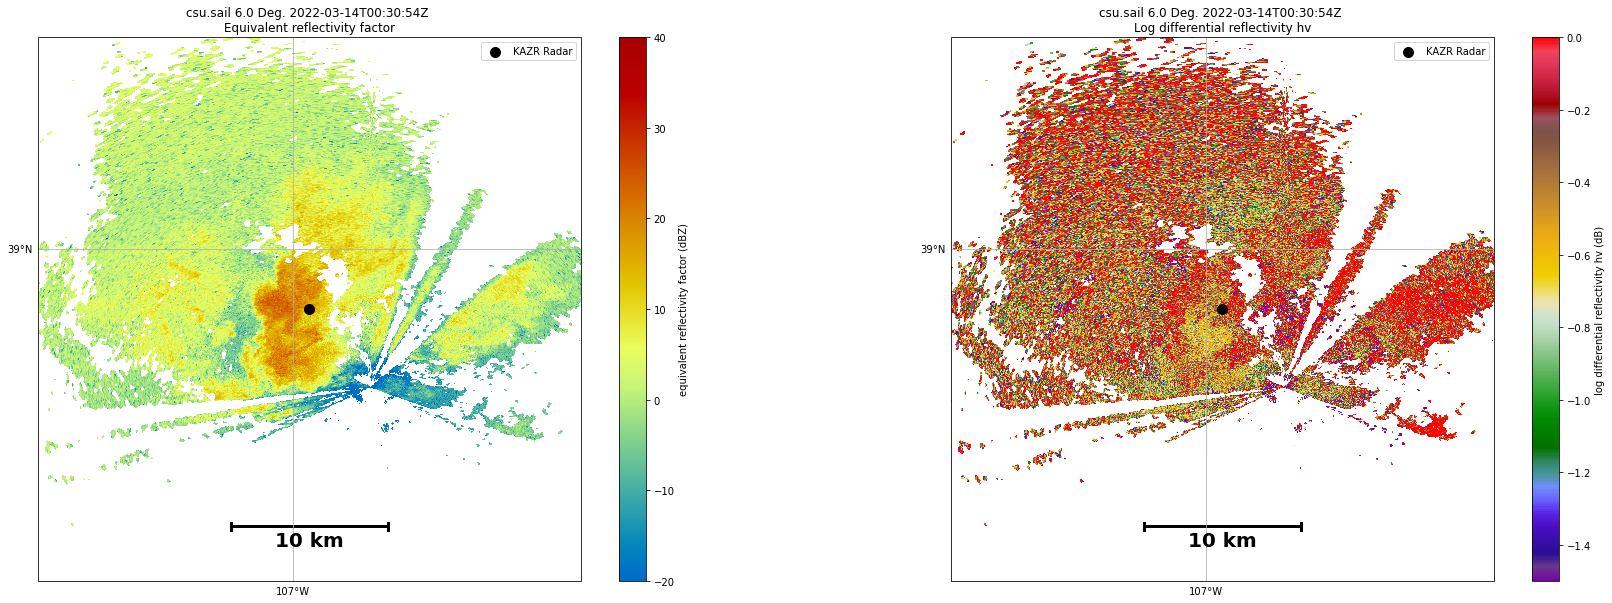

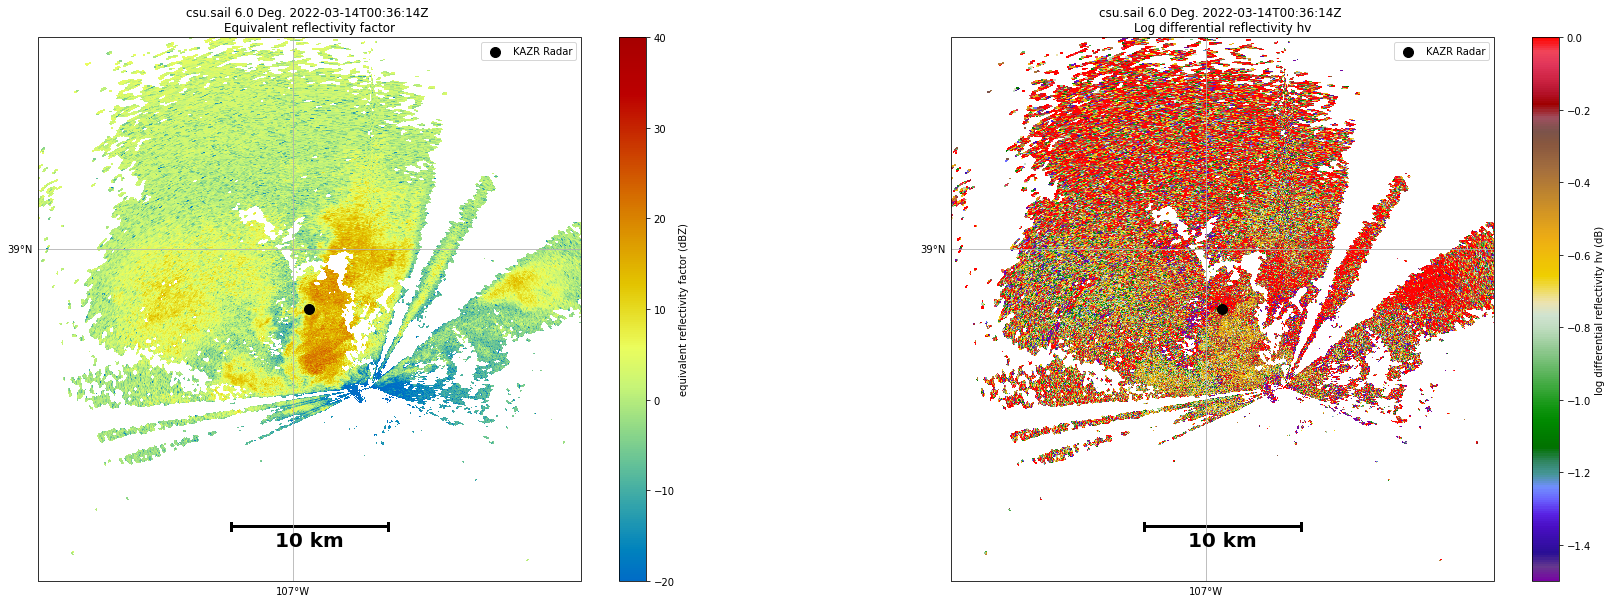

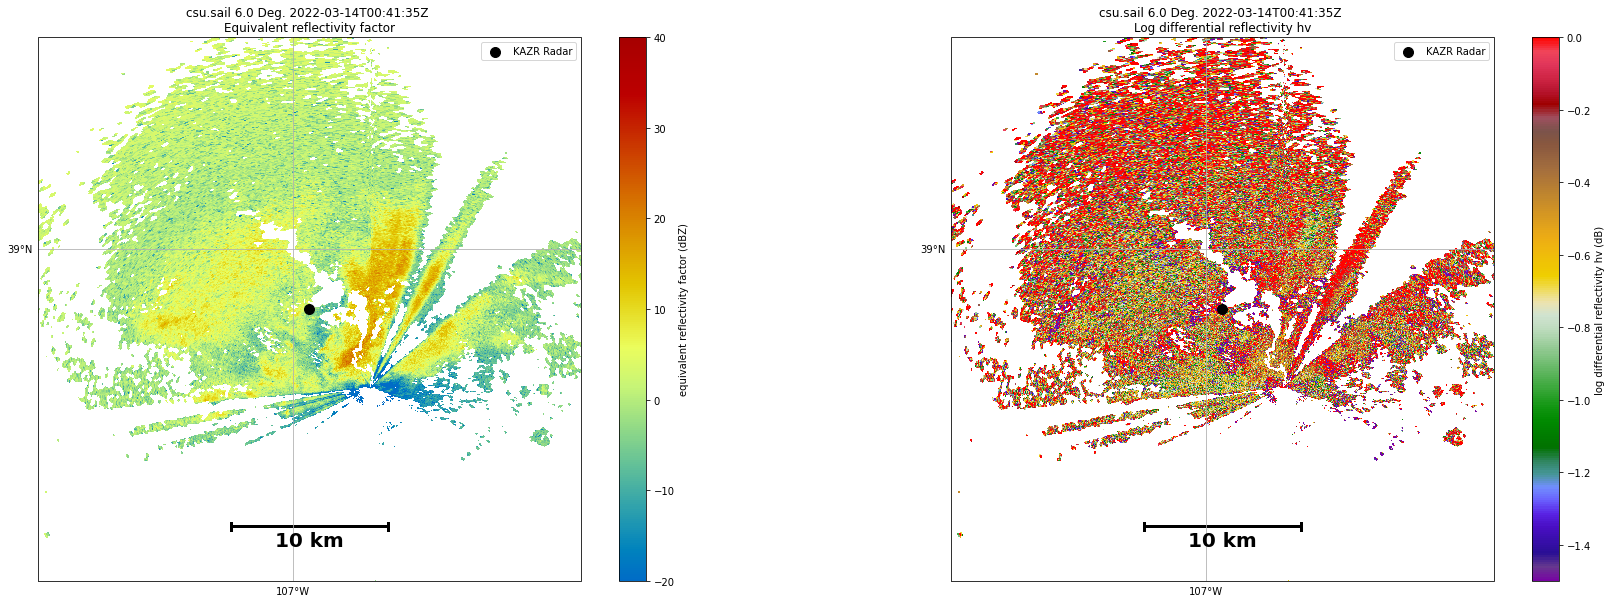

In [37]:
for file in radar_files:
    plot_ppi(file, centerlat=lat, centerlon=lon)